# Assignment: Linear Models
## Foundations of Machine Learning
## Do Q1 and one other question

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


**Q1.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

In [61]:
df = pd.read_csv('./data/Q1_clean.csv')
df = df.rename(columns={'Neighbourhood ':'Neighborhood'}) # make it more American :)
# cleaning to eliminate random property types
df = df[~df['Property Type'].isin(['Hut', 'Bungalow', 'Cabin', 'Castle', 'Chalet', 'Lighthouse','Boat','Treehouse','Villa'])] 
df.head()

,Price,Review Scores Rating,Neighborhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt


1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood`.

In [62]:
df.loc[:,['Price','Neighborhood']].groupby('Neighborhood').describe()
# On average, Manhattan is most expensive, Staten Island is least expensive

Price                                                      \
                 count        mean         std   min     25%    50%    75%   
Neighborhood                                                                 
Bronx            217.0   75.276498   39.755468  10.0   50.00   60.0   90.0   
Brooklyn        8483.0  127.744194  106.041709  20.0   75.00  100.0  150.0   
Manhattan      11756.0  183.676080  170.472765  25.0  103.00  150.0  214.0   
Queens          1577.0   96.538998   61.678602  25.0   60.00   80.0  114.0   
Staten Island     96.0  146.166667  508.462029  35.0   54.75   71.0   99.0   

                        
                   max  
Neighborhood            
Bronx            244.0  
Brooklyn        4500.0  
Manhattan      10000.0  
Queens           950.0  
Staten Island   5000.0

Text(0.5, 1.0, 'Kernel Density Plot of Price (log scale)')

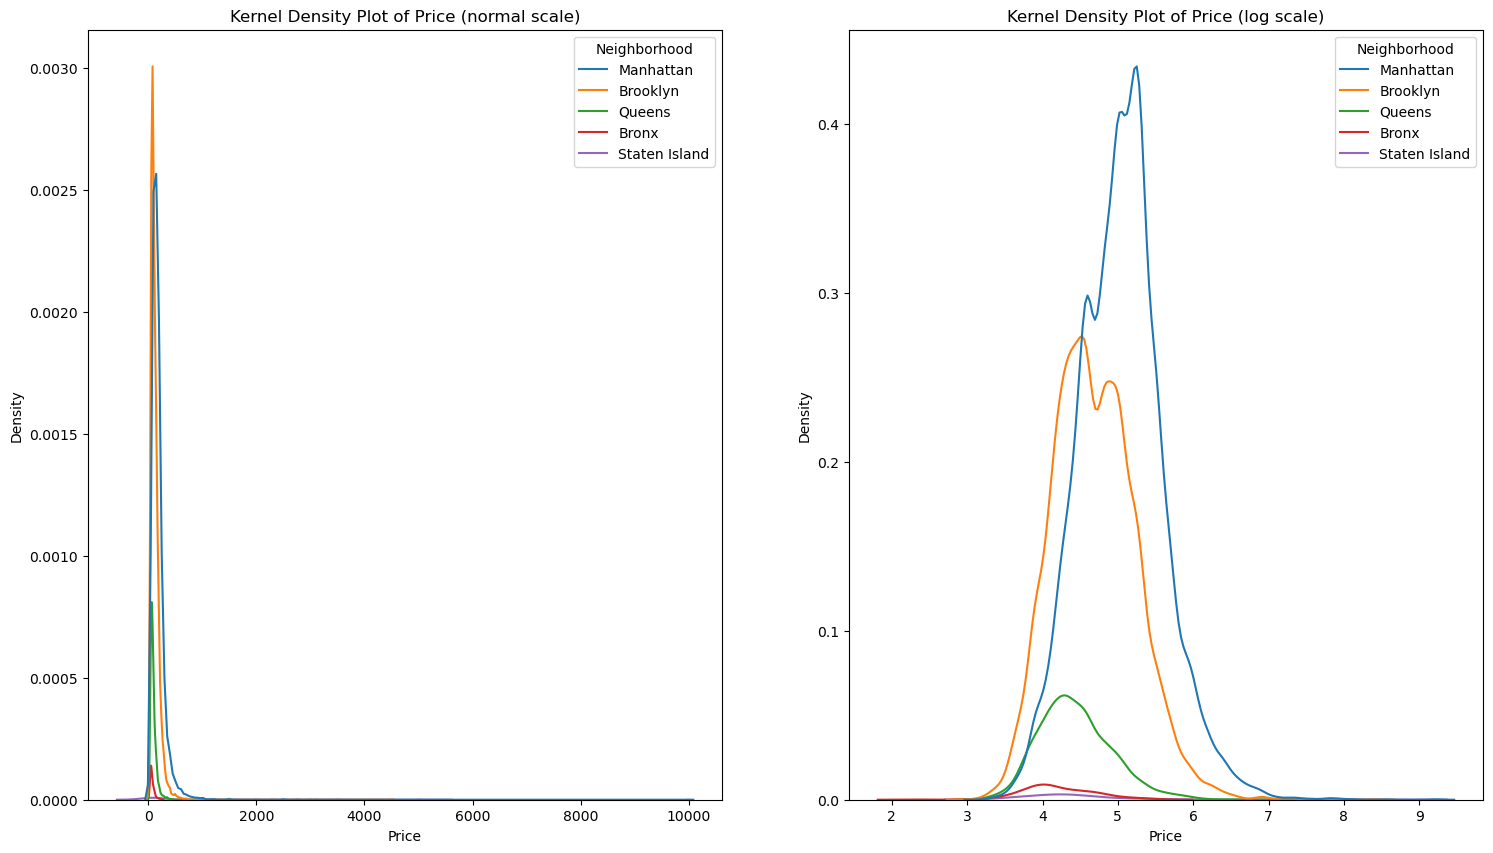

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

p = sns.kdeplot(ax=axes[0], x=df['Price'], hue=df['Neighborhood'])
p.set_title("Kernel Density Plot of Price (normal scale)")

p = sns.kdeplot(ax=axes[1], x=np.log(df['Price']), hue=df['Neighborhood'])
p.set_title("Kernel Density Plot of Price (log scale)")

2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?

In [64]:
y = df['Price']
x = pd.get_dummies(df['Neighborhood'])

regression = linear_model.LinearRegression(fit_intercept=False).fit(x,y)

results = pd.DataFrame({'Neighborhood':regression.feature_names_in_, 'Coefficient': regression.coef_})#,'Orig Means':df.loc[:,['Price','Neighborhood']].groupby('Neighborhood').mean()})
results.head()

,Neighborhood,Coefficient
0,Bronx,75.276498
1,Brooklyn,127.744194
2,Manhattan,183.676080
3,Queens,96.538998
4,Staten Island,146.166667


In [65]:
# for comparison from above: notice the mean prices are the same as the coefficients from the linear regression
df.loc[:,['Price','Neighborhood']].groupby('Neighborhood').mean().loc[:,['Price']] # whiddle result down to mean price per borough
# so, regression is just computing averages as of now

,Price
Neighborhood,
Bronx,75.276498
Brooklyn,127.744194
Manhattan,183.676080
Queens,96.538998
Staten Island,146.166667


3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?

In [66]:
x = pd.get_dummies(df['Neighborhood'], drop_first=True) # change - must drop first when creating dummies
# we can figure out by process of elimination what the last variable is... aka the regression intercept (Bronx, ~75.27)
# now the Bronx is the reference category. Reg intercept is a point where it can base othe values off of - everything is relative to Bronx

regression = linear_model.LinearRegression(fit_intercept=True).fit(x,y)

results = pd.DataFrame({'Neighborhood':regression.feature_names_in_, 'Coefficient': regression.coef_})
# adding reg intercept to new coefficient = coefficient from part 2
results.head()

,Neighborhood,Coefficient
0,Brooklyn,52.467697
1,Manhattan,108.399583
2,Queens,21.262500
3,Staten Island,70.890169


In [67]:
print('regression intercept:',regression.intercept_)

regression intercept: 75.27649769585088


4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?

In [68]:
# y already defined from before as price
x = df.loc[:,['Review Scores Rating', 'Neighborhood']]

X_train, X_test, y_train, y_test = train_test_split(x, y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes
# ^ code from prev assignment

# to predict price, combine the two factors we're looking at... but make neighborhood into dummies
Z_train = pd.concat([X_train['Review Scores Rating'], pd.get_dummies(X_train['Neighborhood'], dtype='int')], axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'], pd.get_dummies(X_test['Neighborhood'], dtype='int')], axis = 1)

reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train,y_train) # Run regression

y_hat = reg.predict(Z_test)
print('R^2:',reg.score(Z_test, y_test))

rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:',rmse)

coefficients = pd.DataFrame({'Variable':reg.feature_names_in_,'Coefficient':reg.coef_})
print('Coefficient on Review Scores Rating:',coefficients['Coefficient'][0])

coefficients
# can then figure out most expensive place, bc Manhattan has highest intercept, so with a 100 rating, the coefficient would multiply that 
# rating to the largest value:
#       100 * 1.032257 + 89.421010 = $192.65 

R^2: 0.01899344978935713
RMSE: 219.58696842035266
Coefficient on Review Scores Rating: 1.1764669858459822


,Variable,Coefficient
0,Review Scores Rating,1.176467
1,Bronx,-29.262276
2,Brooklyn,17.966914
3,Manhattan,75.168456
4,Queens,-10.948289
5,Staten Island,-6.530592


5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?

In [69]:
# y already defined from before as price
x = df.loc[:,['Review Scores Rating', 'Neighborhood', 'Property Type']]

# rest of code basically copied from part 4

X_train, X_test, y_train, y_test = train_test_split(x, y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

# to predict price, combine the three factors we're looking at... but make neighborhood & property type into dummies
Z_train = pd.concat([X_train['Review Scores Rating'], pd.get_dummies(X_train['Neighborhood'], dtype='int'),
                     pd.get_dummies(X_train['Property Type'], dtype='int')], axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'], pd.get_dummies(X_test['Neighborhood'], dtype='int'),
                    pd.get_dummies(X_test['Property Type'], dtype='int')], axis = 1)

reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train,y_train) # Run regression

y_hat = reg.predict(Z_test)
print('R^2:',reg.score(Z_test, y_test))

rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:',rmse)

coefficients = pd.DataFrame({'Variable':reg.feature_names_in_,'Coefficient':reg.coef_})
print('Coefficient on Review Scores Rating:',coefficients['Coefficient'][0])

coefficients
# can then figure out most expensive place, bc Condominium has highest intercept, so with a 100 rating, the coefficient would multiply that 
# rating to the largest value:
#       100 * 1.163468 + 85.809885 = $202.16 

R^2: 0.021921705531316338
RMSE: 219.25899540411385
Coefficient on Review Scores Rating: 1.1634677698804692


,Variable,Coefficient
0,Review Scores Rating,1.163468
1,Bronx,-23.065887
2,Brooklyn,30.850408
3,Manhattan,92.761711
4,Queens,1.434463
5,Staten Island,-5.876506
6,Apartment,-18.168314
7,Bed & Breakfast,-47.239761
8,Camper/RV,-16.557550
9,Condominium,85.809885


6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.

That the coefficient on `Review Scores Rating` decreased slightly from part 4 to part 5 means some of the variation in how `Review Scores Rating` relates to `Neighborhood` can be explained by further separating into `Property Type`, too. Put another way, `Property Type` has an impact on `Neighborhood`, too, so accounting for this makes there be a bit less variation

7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv 
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

<Axes: >

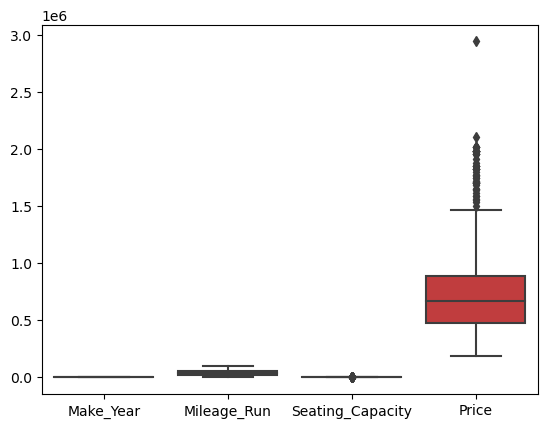

In [70]:
df2 = pd.read_csv('./data/cars_hw.csv')
df2_0 = df2
df2 = df2.drop(['Unnamed: 0','No_of_Owners'], axis=1) # remove unreferenced columns
sns.boxplot(data=df2) #especially note outliers for price and how it is nowhere near the other numeric ones scale

<Axes: >

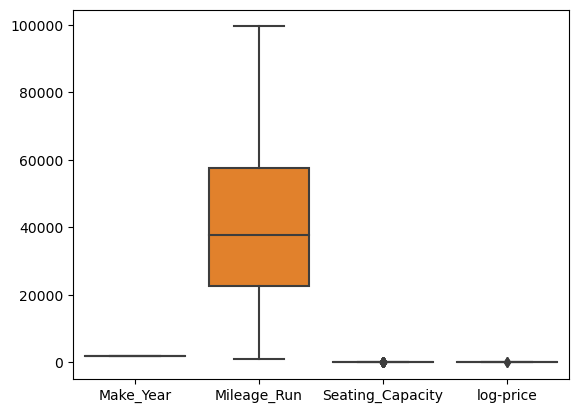

In [71]:
df2['log-price'] = np.log(df2['Price'])
df2 = df2.drop(columns=['Price'])
sns.boxplot(data=df2) # now Mileage_Run is badly scaled

<Axes: >

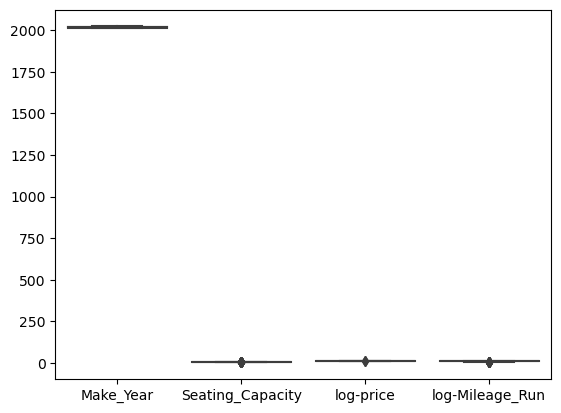

In [72]:
df2['log-Mileage_Run'] = np.log(df2['Mileage_Run'])
df2 = df2.drop(columns=['Mileage_Run'])
sns.boxplot(data=df2) # And now make_year is waaaay off from the other values

<Axes: >

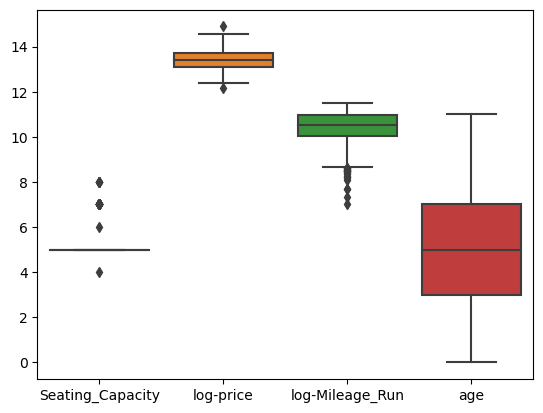

In [73]:
df2['age'] = max(df2['Make_Year'])-df2['Make_Year']
df2 = df2.drop(columns=['Make_Year'])
sns.boxplot(data=df2) # that's a lot better :)

  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

Price                                                    \
               count          mean           std        min        25%   
Make                                                                     
Chevrolet        6.0  4.535000e+05  2.466064e+05   267000.0   288500.0   
Datsun           3.0  2.896667e+05  1.050397e+04   279000.0   284500.0   
Ford            52.0  7.211731e+05  1.409277e+05   290000.0   635000.0   
Honda           73.0  7.989726e+05  2.665091e+05   316000.0   581000.0   
Hyundai        305.0  6.918918e+05  2.791597e+05   248000.0   485000.0   
Jeep             4.0  1.499500e+06  1.525134e+05  1290000.0  1447500.0   
Kia              8.0  1.614750e+06  1.190567e+05  1369000.0  1579000.0   
MG Motors       35.0  1.869457e+06  1.216611e+05  1589000.0  1786500.0   
Mahindra        18.0  1.100167e+06  1.755493e+05   796000.0  1037000.0   
Maruti Suzuki  293.0  5.887850e+05  2.160199e+05   237000.0   411000.0   
Nissan           4.0  8.842500e+05  2.895599e+05   475000.0   782500.0   
Renault         68.0  6.625735e+05  2.148273e+05   287000.0   475000.0   
Skoda            5.0  1.136000e+06  1.070175e+06   436000.0   466000.0   
Tata            23.0  1.055217e+06  5.578305e+05   188000.0   779500.0   
Toyota          50.0  8.003400e+05  2.466900e+05   368000.0   526250.0   
Volkswagen      29.0  6.058276e+05  1.198312e+05   402000.0   542000.0   

                                                
                     50%        75%        max  
Make                                            
Chevrolet       345500.0   537500.0   892000.0  
Datsun          290000.0   295000.0   300000.0  
Ford            707500.0   787000.0  1066000.0  
Honda           785000.0   915000.0  1537000.0  
Hyundai         638000.0   837000.0  1742000.0  
Jeep           1529500.0  1581500.0  1649000.0  
Kia            1628500.0  1705750.0  1741000.0  
MG Motors      1848000.0  1978000.0  2019000.0  
Mahindra       1094500.0  1157000.0  1465000.0  
Maruti Suzuki   527000.0   764000.0  1163000.0  
Nissan          978000.0  1079750.0  1106000.0  
Renault         644000.0   801000.0  1164000.0  
Skoda           538000.0  1299000.0  2941000.0  
Tata            869000.0  1552000.0  2100000.0  
Toyota          894000.0  1023000.0  1092000.0  
Volkswagen      607000.0   699000.0   790000.0

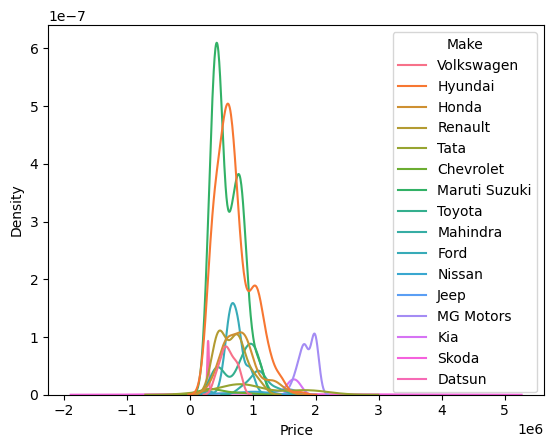

In [74]:
# unscaled/uncleaned version of price
sns.kdeplot(data=df2_0,x='Price',hue='Make')
df2_0.loc[:,['Price','Make']].groupby('Make').describe()

log-price                                                        \
                  count       mean       std        min        25%        50%   
Make                                                                            
Chevrolet           6.0  12.919895  0.480975  12.495004  12.568392  12.752286   
Datsun              3.0  12.576047  0.036311  12.538967  12.558302  12.577636   
Ford               52.0  13.468280  0.210895  12.577636  13.361380  13.469493   
Honda              73.0  13.536318  0.336972  12.663497  13.272506  13.573439   
Hyundai           305.0  13.368511  0.398781  12.421184  13.091904  13.366094   
Jeep                4.0  14.216591  0.105084  14.070153  14.183270  14.240265   
Kia                 8.0  14.292177  0.076877  14.129591  14.272242  14.303105   
MG Motors          35.0  14.439052  0.066263  14.278615  14.395744  14.429615   
Mahindra           18.0  13.898953  0.159906  13.587354  13.851808  13.905680   
Maruti Suzuki     293.0  13.218132  0.371409  12.375815  12.926348  13.174956   
Nissan              4.0  13.641194  0.392610  13.071070  13.537775  13.788723   
Renault            68.0  13.350862  0.331717  12.567237  13.071063  13.375395   
Skoda               5.0  13.640864  0.827046  12.985398  13.051941  13.195614   
Tata               23.0  13.713405  0.615090  12.144197  13.566383  13.675098   
Toyota             50.0  13.535507  0.360112  12.815838  13.171414  13.703461   
Volkswagen         29.0  13.294742  0.203839  12.904207  13.203021  13.316284   

                                     
                     75%        max  
Make                                 
Chevrolet      13.171681  13.701221  
Datsun         12.594587  12.611538  
Ford           13.575984  13.879424  
Honda          13.726679  14.245343  
Hyundai        13.637579  14.370544  
Jeep           14.273586  14.315680  
Kia            14.349515  14.369970  
MG Motors      14.497597  14.518113  
Mahindra       13.961249  14.197366  
Maruti Suzuki  13.546323  13.966513  
Nissan         13.892143  13.916260  
Renault        13.593607  13.967373  
Skoda          14.077105  14.894260  
Tata           14.251370  14.557448  
Toyota         13.838227  13.903521  
Volkswagen     13.457406  13.579788

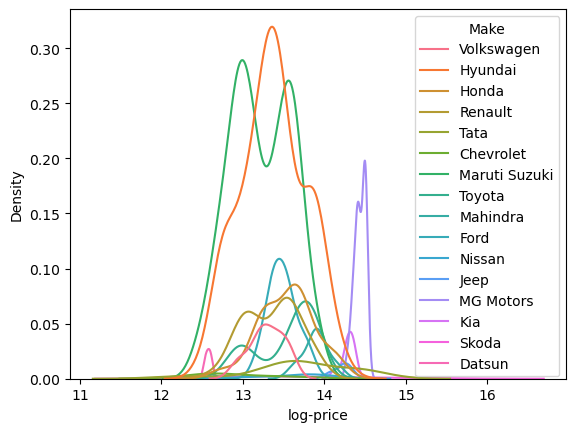

In [75]:
# scaled/cleaned version of price
sns.kdeplot(data=df2,x='log-price',hue='Make')
df2.loc[:,['log-price','Make']].groupby('Make').describe()

It makes sense that both the scaled and unscaled version of the price variable have similar kernel density plots, however the scales and axes are slightly different (because the numbers were scaled). Regardless, in both versions, we can see from both the graph and the description that MG Motors cars are the most expensive (and generally concentrated around that high price), followed by Kia. Jeep comes next, but this is mostly just clear from looking at the mean price description, not the graph. However, we can also see that Hyundai and (I think) Maruti Suzuki have their prices concentrated near each other, but where Hyundai peaks is where Maruti Suzuki dips, and vice versa. It does not appear uncommon to see prices congregate around 1-2 places per make

  3. Split the data into an 80% training set and a 20% testing set.

In [76]:
x2 = df2.loc[:,~df2.columns.isin(['log-price'])]
y2 = df2.loc[:,['log-price']]

X_train, X_test, y_train, y_test = train_test_split(x2, y2, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes


  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

In [170]:
## 1: numeric variables alone
# to predict price, combine the  factors we're looking at
Z_train_n = X_train.loc[:,['Seating_Capacity','log-Mileage_Run','age']]
Z_test_n = X_test.loc[:,['Seating_Capacity','log-Mileage_Run','age']]

reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train_n,y_train) # Run regression

y_hat = reg.predict(Z_test_n)
print('R^2:',reg.score(Z_test_n, y_test))

rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:',rmse)

coefficients = pd.DataFrame({'Variable':reg.feature_names_in_,'Coefficient':reg.coef_[0]})
#coefficients

R^2: -1.4469067973599947
RMSE: 0.6948271433515717


In [171]:
## 2: categorical variables alone
# to predict price, combine the  factors we're looking at
# Categorical regression:
var_cat = ['Make','Body_Type','Color','Fuel_Type','Transmission','Transmission_Type']

# the below didn't work because of some categorical variables not ending up being present in both sets... booooo
"""
Z_train = pd.DataFrame([])
Z_test = pd.DataFrame([])
for var in var_cat:
    Z_train = pd.concat([Z_train, pd.get_dummies( X_train.loc[:,var], drop_first=True, dtype=int)], axis=1, ignore_index=True)
    Z_test = pd.concat([Z_test, pd.get_dummies( X_test.loc[:,var], drop_first=True, dtype=int)], axis=1, ignore_index=True)
"""

# instead, gonna make a giant mega df and the chop it to align with size of Y_test and Y_train
mega_z = pd.concat([X_train, X_test], axis=0, ignore_index=False)
dummy = pd.DataFrame([])
for var in var_cat:
    dummy = pd.concat([dummy, pd.get_dummies(mega_z.loc[:,var], drop_first=True, dtype=int)], axis=1, ignore_index=False)

# chop up the set so it fully aligns with Y_test/Y_train
Z_train_c = dummy.iloc[0:X_train.shape[0],:]
Z_test_c = dummy.iloc[X_train.shape[0]:,:]

reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train_c,y_train) # Run regression

y_hat = reg.predict(Z_test_c)
print('R^2:',reg.score(Z_test_c, y_test))

rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:',rmse)

coefficients = pd.DataFrame({'Variable':reg.feature_names_in_,'Coefficient':reg.coef_[0]})
#coefficients

R^2: -1.9773472017092537
RMSE: 0.7664481907640974


In [172]:
## 3: all together

# add the numerical variables to dummy df
for var in ['Seating_Capacity','log-Mileage_Run','age']:
    dummy = pd.concat([dummy, mega_z.loc[:,var]], axis=1, ignore_index=False)

# then all else same as before:
    
# chop up the set so it fully aligns with Y_test/Y_train
Z_train_b = dummy.iloc[0:X_train.shape[0],:]
Z_test_b = dummy.iloc[X_train.shape[0]:,:]

reg = linear_model.LinearRegression(fit_intercept=False).fit(Z_train_b,y_train) # Run regression

y_hat = reg.predict(Z_test_b)
print('R^2:',reg.score(Z_test_b, y_test))

rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:',rmse)

coefficients = pd.DataFrame({'Variable':reg.feature_names_in_,'Coefficient':reg.coef_[0]})
#coefficients

R^2: 0.13927528929022792
RMSE: 0.4120977067606409


I got a ridiculously bad $r^2$ value when doing just the categorical regression, likely because there were so many variables (40!) and it led to severe overfitting. However, I also had a negative $r^2$ value when running it just on the numerical variables, which is also surprising. Interestingly, the best results I found were when I put everything together - my $r^2$ value was positive (0.139), and the RMSE was also significantly lower (0.28 for numerical, 0.35 for categorical) than in the other model. Therefore, expanding the set of features helped significantly

  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?

In [216]:
def regression(d, flag):
    expander = PolynomialFeatures(degree=d,include_bias=False)
    #
    # Expand variables:
    Z = expander.fit_transform(Z_test_n)
    
    # new dfs w names :)
    names = expander.get_feature_names_out()
    X_test_d = pd.DataFrame(data=Z, columns = names)
    Z = expander.fit_transform(Z_train_n)
    names = expander.get_feature_names_out()
    X_train_d = pd.DataFrame(data=Z, columns = names)

    ## fill new dfs
    # x_train
    X_train_d.reset_index(drop=True, inplace=True)
    Z_train_c.reset_index(drop=True, inplace=True)
    X_train_all = pd.concat([X_train_d, Z_train_c], axis=1, ignore_index=True)
    # x_test:
    X_test_d.reset_index(drop=True, inplace=True)
    Z_test_c.reset_index(drop=True, inplace=True)
    X_test_all = pd.concat([X_test_d, Z_test_c], axis=1, ignore_index=True)

    # Regression + metrics:
    reg_all = linear_model.LinearRegression().fit(X_train_all,y_train) # Run regression
    if flag:
        print(d, ' Rsq: ', reg_all.score(X_test_all,y_test)) # R2
        y_hat_all = reg_all.predict(X_test_all)
        rmse_all = np.sqrt( np.mean( (y_test - y_hat_all)**2 ))
        print(d, 'RMSE: ', rmse_all) # R2
    else:
        return reg_all.predict(X_test_all)

for d in np.arange(1,5):
    regression(d, True)

1  Rsq:  0.8302439092554681
1 RMSE:  0.18301249627592392
2  Rsq:  0.8376255834182197
2 RMSE:  0.1789892152298679
3  Rsq:  0.7458709868863724
3 RMSE:  0.2239211866861788
4  Rsq:  -1184645379.4682317
4 RMSE:  15288.407314497368


  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

Text(0, 0.5, 'predicted price')

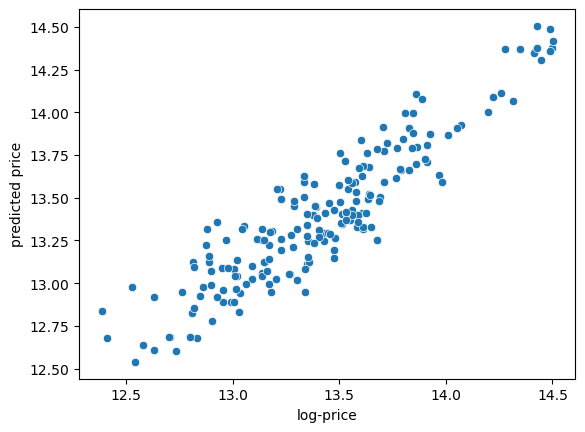

In [253]:
full_y_hat = regression(2, False) # where d=2 from above bc highest r^2 + lowest RMSE
real_y = y_test.reset_index(drop=True)
full_y_hat_df = pd.DataFrame(full_y_hat)
ys = pd.concat([real_y, full_y_hat_df], axis=1)
ys['resid'] = ys['log-price'] - ys[0]
sns.scatterplot(data=ys, x=ys['log-price'], y=ys[0]).set_ylabel('predicted price')

They definitely do line up along the diagonal

<Axes: xlabel='resid', ylabel='Density'>

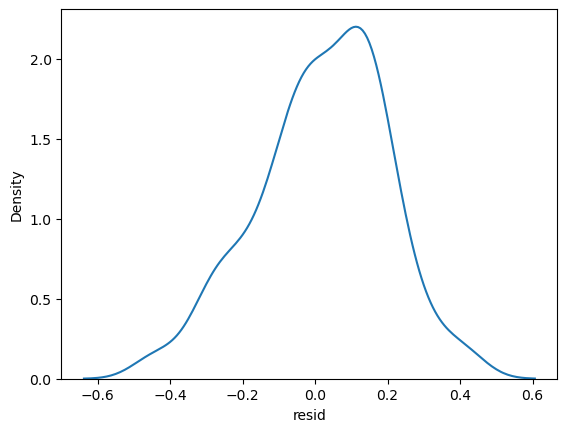

In [254]:
sns.kdeplot(data=ys['resid'])

The residulars are roughly bell shaped, and are aligned around 0 in the kernel density plot above

The model's residuals in the kernel density plot don't have a perfect bell shape. It's a bit lopsided with more weight positive of zero, and the average appears to be a bit above 0 as well (and below, I calculate the mean to be 0.02, which is very slighly above 0). The max and min are nearly reflections of each other ($-0.451$ vs $0.420$), but the point marking the 75th percentile is far above it's reflective counterpart marking the 25th percentile ($0.143$ vs $-0.082$). This means more of the residuals (and therefore more of the error) tends to be greater than the actual values. However, the fact it does appear to roughly line up in a diagonal is reassuring for the model's validity, as it demonstrates there is a positive correlation between predicted and actual prices

In [256]:
ys['resid'].describe()

count    196.000000
mean       0.020037
std        0.178320
min       -0.451724
25%       -0.082042
50%        0.029366
75%        0.142797
max        0.420275
Name: resid, dtype: float64

**Q3.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent 
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q4.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where 
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{alignat*}{3}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{alignat*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{alignat*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

which can be written in terms of sample covariance and sample variance as:

\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{alignat*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)

**Q5.** 
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?